In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

## Cross-Validation

In the previous chapter, we observed that we needed a more accurate way of simulating the test error to manage the bias-variance trade off. Cross-validation provides a method of estimating our model error using a single observed dataset by separating data used for training from the data used for model selection and final accuracy. 

## Train-Validation-Test Split

One way to accomplish this is to split the original dataset into three disjoint subsets:

* Training set: The data used to fit the model.
* Validation set: The data used to select features.
* Test set: The data used to report the model's final accuracy.

After splitting, we select a set of features and a model based on the following procedure:

1. For each potential set of features, fit a model using the training set. The error of a model on the training set is its *training error*.
1. Check the error of each model on the validation set: its *validation error*. Select the model that achieves the lowest validation error. This is the final choice of features and model.
1. Calculate the *test error*, error of the final model on the test set. This is the final reported accuracy of the model. We are forbidden from adjusting the features or model to decrease test error; doing so effectively converts the test set into a validation set. Instead, we must collect a new test set after making further changes to the features or the model.

This process allows us to more accurately determine the model to use than using the training error alone.

**Size of the train-validation-test split**

The train-validation-test split commonly uses 70% of the data as the training set, 15% as the validation set, and the remaining 15% as the test set. Increasing the size of the training set helps model accuracy but causes more variation in the validation and test error.

## Training Error and Test Error

A model is of little use to us if it fails to generalize to unseen data from the population. The test error provides an accurate representation of the model's performance on new data since we do not use the test set to train the model or select features.

In general, the training error decreases as we add complexity to our model with additional features or more complex prediction mechanisms. The test error, on the other hand, decreases up to a certain amount of complexity then increases again as the model overfits the training set.

![feature_train_test_error.png](https://raw.githubusercontent.com/DS-100/textbook/master/assets/feature_train_test_error.png)

## K-Fold Cross-Validation

In Chapter 14.3, we mentioned the method of the **train-validation split** method to simulate test error through the validation set. However, with this method the validation error may be prone to high variance because the evaluation of the error may depend heavily on which points end up in the training and validation sets.

To tackle this problem, we can run the train-validation split multiple times on the same dataset. The dataset is divided into *k* equally-sized subsets (*$k$ folds*), and the train-validation split is repeated *k* times. Each time, one of the *k* folds is used as the validation set, and the remaining *k-1* folds are used as the training set. We report the model's final validation error as the average of the $ k $ validation errors from each trial. This method is called **k-fold cross-validation**. The biggest advantage of this method is that every data point is used for validation exactly once and for training *k-1* times.

The diagram below illustrates the technique when using five folds:

![feature_5_fold_cv.jpg](https://github.com/DS-100/textbook/blob/master/assets/feature_5_fold_cv.jpg?raw=true)

The biggest advantage of this method is that every data point is used for validation exactly once and for training *k-1* times. Typically, a *k* between 5 to 10 is used, but *k* remains an unfixed parameter. When *k* is small, the error estimate has a lower variance (many validation points) but has a higher bias (fewer training points). Vice versa, with large *k* the error estimate has lower bias but has higher variance. 

$k$-fold cross-validation takes more computation time than the train-validation split since we typically have to refit each model from scratch for each fold. However, it computes a more accurate validation error by averaging multiple errors together for each model.

The `scikit-learn` library provides a convenient [`sklearn.model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class to implement $k$-fold cross-validation.

## Bias-Variance Tradeoff

K-fold cross-validation helps us manage the bias-variance tradeoff more accurately. Intuitively, the validation error estimates test error by checking the model's performance on a dataset not used for training; this allows us to estimate both model bias and model variance. K-fold cross-validation also incorporates the fact that the noise in the test set only affects the noise term in the bias-variance decomposition whereas the noise in the training set affects both bias and model variance To choose the final model to use, we select the one that has the lowest validation error.



## Example: Model Selection for Ice Cream Ratings
We will use the complete model selection process, including cross-validation, to select a model that predicts ice cream ratings from ice cream sweetness. The complete ice cream dataset and a scatter plot of the overall rating versus ice cream sweetness are shown below.

In [3]:
# HIDDEN
ice = pd.read_csv('icecream.csv')
transformer = PolynomialFeatures(degree=2)
X = transformer.fit_transform(ice[['sweetness']])

clf = LinearRegression(fit_intercept=False).fit(X, ice[['overall']])
xs = np.linspace(3.5, 12.5, 300).reshape(-1, 1)
rating_pred = clf.predict(transformer.transform(xs))

#ice.plot.scatter('sweetness', 'overall')
#plt.plot(xs, rating_pred)
#plt.title('Degree 2 polynomial fit');

temp = pd.DataFrame(xs, columns = ['sweetness'])
temp['overall'] = rating_pred

np.random.seed(42)
x_devs = np.random.normal(scale=0.2, size=len(temp))
y_devs = np.random.normal(scale=0.2, size=len(temp))
temp['sweetness'] = np.round(temp['sweetness'] + x_devs, decimals=2)
temp['overall'] = np.round(temp['overall'] + y_devs, decimals=2)

ice = pd.concat([temp, ice])

In [4]:
ice

,sweetness,overall
0,3.60,3.09
1,3.50,3.17
2,3.69,3.46
...,...,...
6,11.00,5.90
7,11.70,5.50
8,11.90,5.40


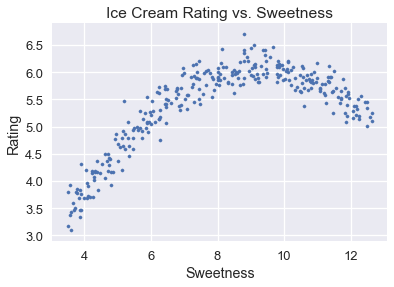

In [5]:
# HIDDEN
plt.scatter(ice['sweetness'], ice['overall'], s=10)
plt.title('Ice Cream Rating vs. Sweetness')
plt.xlabel('Sweetness')
plt.ylabel('Rating');

Using degree 10 polynomial features on the dataset below results in a perfectly accurate model for the 10 datapoints. Unfortunately, this model fails to generalize to previously-unseen data from the population.

In [8]:
# HIDDEN
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

ice2 = pd.read_csv('icecream.csv')
trans_ten = PolynomialFeatures(degree=10)
X_ten = trans_ten.fit_transform(ice2[['sweetness']])
y = ice2['overall']

clf_ten = LinearRegression(fit_intercept=False).fit(X_ten, y)

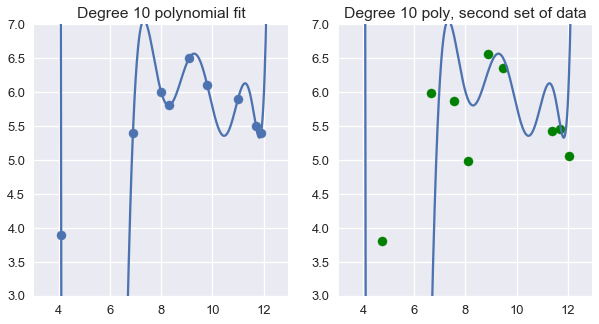

In [9]:
# HIDDEN
np.random.seed(1)
x_devs = np.random.normal(scale=0.4, size=len(ice2))
y_devs = np.random.normal(scale=0.4, size=len(ice2))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(ice2['sweetness'], ice2['overall'])
xs = np.linspace(3.5, 12.5, 1000).reshape(-1, 1)
ys = clf_ten.predict(trans_ten.transform(xs))
plt.plot(xs, ys)
plt.title('Degree 10 polynomial fit')
plt.ylim(3, 7);

plt.subplot(122)
ys = clf_ten.predict(trans_ten.transform(xs))
plt.plot(xs, ys)
plt.scatter(ice2['sweetness'] + x_devs,
            ice2['overall'] + y_devs,
            c='g')
plt.title('Degree 10 poly, second set of data')
plt.ylim(3, 7);

Instead of the above method, we first partition our data into training, validation, and test datasetsusing `scikit-learn`'s [`sklearn.model_selection.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method to perform a 70/30% train-test split.

In [11]:
from sklearn.model_selection import train_test_split

test_size = 92

X_train, X_test, y_train, y_test = train_test_split(
    ice[['sweetness']], ice['overall'], test_size=test_size)


print(f'  Training set size: {len(X_train)}')
print(f'      Test set size: {len(X_test)}')

  Training set size: 217
      Test set size: 92


We now fit polynomial regression models using the training set, one for each polynomial degree from 1 to 10.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# First, we add polynomial features to X_train
transformers = [PolynomialFeatures(degree=deg)
                for deg in range(1, 11)]
X_train_polys = [transformer.fit_transform(X_train)
                 for transformer in transformers]

# Display the X_train with degree 5 polynomial features
X_train_polys[4]

array([[     1.  ,     11.46,    131.33,   1505.06,  17247.99, 197661.96],
       [     1.  ,      8.  ,     64.  ,    512.  ,   4096.  ,  32768.  ],
       [     1.  ,      4.71,     22.18,    104.49,    492.13,   2317.95],
       ...,
       [     1.  ,      6.88,     47.33,    325.66,   2240.55,  15414.95],
       [     1.  ,      4.63,     21.44,     99.25,    459.54,   2127.67],
       [     1.  ,      6.74,     45.43,    306.18,   2063.67,  13909.11]])

We will then perform 5-fold cross-validation on the 10 featurized datasets. To do so, we will define a function that:
1. Uses the [`KFold.split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function to get 5 splits on the training data. Note that `split` returns the indices of the data for that split.
2. For each split, select out the rows and columns based on the split indices and features.
3. Fit a linear model on the training split.
4. Compute the mean squared error on the validation split.
5. Return the average error across all cross validation splits.

In [49]:
from sklearn.model_selection import KFold

def mse_cost(y_pred, y_actual):
    return np.mean((y_pred - y_actual) ** 2)

def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train,split_Y_train)
        
        # Compute the RMSE on the validation split
        error = mse_cost(split_Y_valid,model.predict(split_X_valid))
        
        validation_errors.append(error)
    
    #average validation errors
    return np.mean(validation_errors)

In [50]:
# We train a linear regression classifier for each featurized dataset and perform cross-validation
# We set fit_intercept=False for our linear regression classifier since 
# the PolynomialFeatures transformer adds the bias column for us.

cross_validation_errors = [compute_CV_error(LinearRegression(fit_intercept=False), X_train_poly, y_train)
                     for X_train_poly in X_train_polys]

In [51]:
# HIDDEN
cv_df = pd.DataFrame({'Validation Error': cross_validation_errors}, index=range(1, 11))
cv_df.index.name = 'Degree'
pd.options.display.max_rows = 20
display(cv_df)
pd.options.display.max_rows = 7

,Validation Error
Degree,
1,0.332086
2,0.046725
3,0.047069
4,0.048161
5,0.048352
6,0.048653
7,0.048578
8,0.048877
9,0.051174


We can see that as we use higher degree polynomial features, the validation error decreases and increases again.

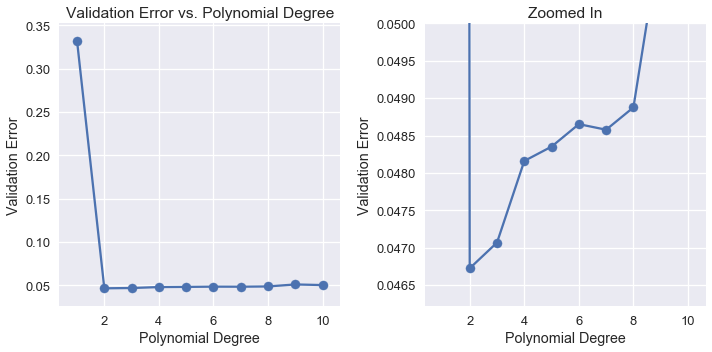

In [35]:
# HIDDEN
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(cv_df.index, cv_df['Validation Error'])
plt.scatter(cv_df.index, cv_df['Validation Error'])
plt.title('Validation Error vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error');

plt.subplot(122)
plt.plot(cv_df.index, cv_df['Validation Error'])
plt.scatter(cv_df.index, cv_df['Validation Error'])
plt.ylim(0.046225, 0.05)
plt.title('Zoomed In')
plt.xlabel('Polynomial Degree')
plt.ylabel('Validation Error')

plt.tight_layout();

Examining the validation errors reveals that the most accurate model only used degree 2 polynomial features. Thus, we select the degree 2 polynomial model as our final model and fit it on the all of the training data at once. Then, we compute its error on the test set.

In [1]:
# HIDDEN
best_trans = transformers[1]
best_model = LinearRegression(fit_intercept=False).fit(X_train_polys[1], y_train)

training_error = mse_cost(best_model.predict(X_train_polys[1]), y_train)
validation_error = cross_validation_errors[1]
test_error = mse_cost(best_model.predict(best_trans.transform(X_test)), y_test)

print('Degree 2 polynomial')
print(f'  Training error: {training_error:0.5f}')
print(f'Validation error: {validation_error:0.5f}')
print(f'      Test error: {test_error:0.5f}')

NameError: name 'transformers' is not defined

For future reference, `scikit-learn` has a [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) to automatically perform cross-validation, so we don't have to break the data into training and validation sets yourself. 

Also, note that the test error is higher than the validation error which is higher than the training error. 

## Summary

We use the widely useful cross-validation technique to manage the bias-variance tradeoff. After computing a train-validation-test split on the original dataset, we use the following procedure to train and choose a model.

1. For each potential set of features, fit a model using the training set. The error of a model on the training set is its *training error*.
1. Check the error of each model on the validation set using $k$-fold cross-validation: its *validation error*. Select the model that achieves the lowest validation error. This is the final choice of features and model.
1. Calculate the *test error*, error of the final model on the test set. This is the final reported accuracy of the model. We are forbidden from adjusting the model to increase test error; doing so effectively converts the test set into a validation set. Instead, we must collect a new test set after making further changes to the model.